<h1>Table of Contents<span class="tocSkip"></span></h1>
<div class="toc"><ul class="toc-item"><li><span><a href="#Sentiment-classification-of-comments-using-BERT" data-toc-modified-id="Sentiment-classification-of-comments-using-BERT-1"><span class="toc-item-num">1&nbsp;&nbsp;</span>Sentiment classification of comments using BERT</a></span><ul class="toc-item"><li><span><a href="#Data-Description" data-toc-modified-id="Data-Description-1.1"><span class="toc-item-num">1.1&nbsp;&nbsp;</span>Data Description</a></span></li></ul></li><li><span><a href="#Preprocessing" data-toc-modified-id="Preprocessing-2"><span class="toc-item-num">2&nbsp;&nbsp;</span>Preprocessing</a></span><ul class="toc-item"><li><span><a href="#Loading-Libraries" data-toc-modified-id="Loading-Libraries-2.1"><span class="toc-item-num">2.1&nbsp;&nbsp;</span>Loading Libraries</a></span></li><li><span><a href="#Loading-and-viewing-data" data-toc-modified-id="Loading-and-viewing-data-2.2"><span class="toc-item-num">2.2&nbsp;&nbsp;</span>Loading and viewing data</a></span></li><li><span><a href="#Text-preprocessing-with-BERT" data-toc-modified-id="Text-preprocessing-with-BERT-2.3"><span class="toc-item-num">2.3&nbsp;&nbsp;</span>Text preprocessing with BERT</a></span></li></ul></li><li><span><a href="#Models-training" data-toc-modified-id="Models-training-3"><span class="toc-item-num">3&nbsp;&nbsp;</span>Models training</a></span><ul class="toc-item"><li><span><a href="#Logistic-Regression" data-toc-modified-id="Logistic-Regression-3.1"><span class="toc-item-num">3.1&nbsp;&nbsp;</span>Logistic Regression</a></span></li><li><span><a href="#LogisticRegression-test" data-toc-modified-id="LogisticRegression-test-3.2"><span class="toc-item-num">3.2&nbsp;&nbsp;</span>LogisticRegression test</a></span></li><li><span><a href="#Comparing-Models-with-Standard-Hyperparameters" data-toc-modified-id="Comparing-Models-with-Standard-Hyperparameters-3.3"><span class="toc-item-num">3.3&nbsp;&nbsp;</span>Comparing Models with Standard Hyperparameters</a></span></li><li><span><a href="#RandomForestClassifier" data-toc-modified-id="RandomForestClassifier-3.4"><span class="toc-item-num">3.4&nbsp;&nbsp;</span>RandomForestClassifier</a></span></li><li><span><a href="#SVC" data-toc-modified-id="SVC-3.5"><span class="toc-item-num">3.5&nbsp;&nbsp;</span>SVC</a></span></li><li><span><a href="#DummyClassifier" data-toc-modified-id="DummyClassifier-3.6"><span class="toc-item-num">3.6&nbsp;&nbsp;</span>DummyClassifier</a></span></li></ul></li><li><span><a href="#Conclusions" data-toc-modified-id="Conclusions-4"><span class="toc-item-num">4&nbsp;&nbsp;</span>Conclusions</a></span></li><li><span><a href="#Checklist" data-toc-modified-id="Checklist-5"><span class="toc-item-num">5&nbsp;&nbsp;</span>Checklist</a></span></li></ul></div>

# Sentiment classification of comments using BERT

**Key points:** BERT, text preprocessing, lemmatization, text classification

An online store needs a model for classifying comments into positive and negative.
We have a dataset with markup about the mood of comments.

**Task:** build a model with a quality metric value *F1* not less than 0.75.


## Data Description

The data is in the file `toxic_comments.csv`.  
The *text* column contains the comment text, and *toxic* is the target feature.

# Preprocessing

## Loading Libraries

In [1]:
import numpy as np
import pandas as pd
import torch
import transformers
import matplotlib.pyplot as plt
import seaborn as sns
from tqdm import notebook
from sklearn.linear_model import LogisticRegression
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
from sklearn.metrics import f1_score
import lazypredict
from lazypredict.Supervised import LazyClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import StandardScaler

from nltk.stem import WordNetLemmatizer
import re
import nltk
from sklearn.datasets import load_files
nltk.download('stopwords')
import pickle
from nltk.corpus import stopwords
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfTransformer
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics import classification_report

C:\ProgramData\Anaconda3\lib\site-packages\sklearn\utils\deprecation.py:143: FutureWarning: The sklearn.utils.testing module is  deprecated in version 0.22 and will be removed in version 0.24. The corresponding classes / functions should instead be imported from sklearn.utils. Anything that cannot be imported from sklearn.utils is now part of the private API.
  warnings.warn(message, FutureWarning)
[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\Andrey\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


## Loading and viewing data

In [2]:
try:
    data = pd.read_csv('/datasets/toxic_comments.csv')
except:
    data = pd.read_csv('toxic_comments.csv')

In [3]:
data.head()

,text,toxic
0,Explanation\nWhy the edits made under my usern...,0
1,D'aww! He matches this background colour I'm s...,0
2,"Hey man, I'm really not trying to edit war. It...",0
3,"""\nMore\nI can't make any real suggestions on ...",0
4,"You, sir, are my hero. Any chance you remember...",0


In [4]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 159571 entries, 0 to 159570
Data columns (total 2 columns):
 #   Column  Non-Null Count   Dtype 
---  ------  --------------   ----- 
 0   text    159571 non-null  object
 1   toxic   159571 non-null  int64 
dtypes: int64(1), object(1)
memory usage: 2.4+ MB


<AxesSubplot:title={'center':'Distribution of "normal" and "toxic" comments'}, ylabel='Frequency'>

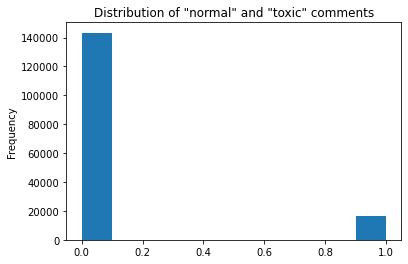

In [5]:
data['toxic'].plot(kind='hist', title='Distribution of "normal" and "toxic" comments')

**Conclusion:**
- Comments need to be processed and translated into a form suitable for analysis
- There is an imbalance in the target feature, we need to take it into account in further work

## Text preprocessing with BERT

In [6]:
tokenizer = transformers.BertTokenizer.from_pretrained('bert-base-uncased')

In [7]:
tokenized = data['text'].apply(lambda x: tokenizer.encode(x, add_special_tokens=True, 
                                                          truncation=True ))

In [8]:
max_len = 0
for i in tokenized.values:
    if len(i) > max_len:
        max_len = len(i)

padded = np.array([i + [0]*(max_len - len(i)) for i in tokenized.values])

attention_mask = np.where(padded != 0, 1, 0)

In [9]:
attention_mask.shape

(159571, 512)

In [10]:
config = transformers.BertConfig.from_pretrained('bert-base-uncased')
model = transformers.BertModel.from_pretrained('bert-base-uncased', config=config)

In [11]:
batch_size = 100
embeddings = []

for i in notebook.tqdm(range(padded.shape[0] // batch_size)):
    batch = torch.LongTensor(padded[batch_size*i:batch_size*(i+1)])
    attention_mask_batch = torch.LongTensor(
    attention_mask[batch_size*i:batch_size*(i+1)])
    with torch.no_grad():
        batch_embeddings = model(batch, attention_mask=attention_mask_batch)
    embeddings.append(batch_embeddings[0][:,0,:].numpy())

KeyboardInterrupt: 

In [ ]:
embeddings1 = embeddings

In [ ]:
features = np.concatenate(embeddings1)

In [ ]:
features.shape

In [ ]:
features = np.concatenate(embeddings)
target = data['toxic']

train_features, valid_features, train_target, valid_target = train_test_split(
features, target, test_size=0.4, random_state = 42)

valid_features, test_features, valid_target, test_target = train_test_split(
valid_features, valid_target, test_size=0.5, random_state = 42)

# Models training

In [ ]:
print(train_features.shape, train_target.shape)
print(valid_features.shape, valid_target.shape)
print(test_features.shape, test_target.shape)

## Logistic Regression

In [ ]:
%%time

best_model = None
best_result = 0
best_p1 = 0
best_p2 = 0

for p1 in [10000, 1000, 500, 350, 200, 100, 10, 1.0, 0.1, 0.01]:
    for p2 in ['balanced', 'unbalanced']:
            model =  LogisticRegression(max_iter = 10000, C=p1, random_state=42, class_weight=p2)
            model.fit(train_features, train_target)
            predicted_valid = model.predict(valid_features)
            result = f1_score(predicted_valid, valid_target)
            if result > best_result:
                best_model = model
                best_result = result
                best_p1 = p1
                best_p2 = p2
                report = classification_report(valid_target, predicted_valid)
                    
print("valid F1:", best_result, "best parameter 1:", best_p1, ", best parameter 2:", best_p2)
print()
print(report)
print()

## LogisticRegression test

In [ ]:
model = LogisticRegression(max_iter = 10000, C=best_p1, random_state=42, class_weight=best_p2)

In [ ]:
model.fit(train_features, train_target)

predictions_valid = model.predict(valid_features)
predictions = model.predict(test_features)

In [ ]:
print('F1 score valid:', f1_score(valid_target, predictions_valid))
print('F1 score test:', f1_score(test_target, predictions))

In [ ]:
print(classification_report(test_target, predictions))

## Comparing Models with Standard Hyperparameters

In [ ]:
clf = LazyClassifier(verbose=0,ignore_warnings=True, custom_metric=None)

models_train,predictions_train = clf.fit(train_features, valid_features, train_target, valid_target)
models_test,predictions_test = clf.fit(train_features, test_features, train_target, test_target)

models_train

In [ ]:
models_test

In [ ]:
plt.figure(figsize=(8, 8))
plt.title('F1 score of test data for different models')
sns.set_theme(style="whitegrid")
ax = sns.barplot(y=models_test.index, x="F1 Score", data=models_train)

## RandomForestClassifier

In [ ]:
%%time

best_model = None
best_result = 0
best_p1 = 0
best_p2 = 0

for p1 in range(1, 50, 10):
    for p2 in range (1, 100, 10):
            model =  RandomForestClassifier(max_depth=p1, n_estimators=p2, random_state=42, class_weight='balanced')
            model.fit(train_features, train_target)
            predicted_valid = model.predict(valid_features)
            result = f1_score(predicted_valid, valid_target)
            if result > best_result:
                best_model = model
                best_result = result
                best_p1 = p1
                best_p2 = p2
                    
print("valid F1:", best_result, "best parameter 1:", best_p1, ", best parameter 2:", best_p2)
print()

In [ ]:
model = RandomForestClassifier(max_depth=21, n_estimators=51, random_state=42, class_weight='balanced')
model.fit(train_features, train_target)

predictions = model.predict(test_features)

print('F1 score test:', f1_score(test_target, predictions))

## SVC

In [ ]:
clf = make_pipeline(StandardScaler(), SVC(gamma='auto'))
clf.fit(train_features, train_target)
#Pipeline(steps=[('standardscaler', StandardScaler()), ('svc', SVC(gamma='auto'))])

predictions_valid = clf.predict(valid_features)
predictions = clf.predict(test_features)

print('F1 score valid:', f1_score(valid_target, predictions_valid))
print('F1 score test:', f1_score(test_target, predictions))

## DummyClassifier

In [ ]:
from sklearn.dummy import DummyClassifier
dummy_clf = DummyClassifier(strategy="most_frequent")
dummy_clf.fit(train_features, train_target)
dummy_predictions = dummy_clf.predict(test_features)
print('F1 score test:', f1_score(test_target, dummy_predictions))

In [ ]:
print(classification_report(test_target, dummy_predictions))

# Conclusions

1. The best result was shown by the logistic regression model and SVC - F1 score: 0.75 on test data
2. For training the model, we selected only 4800 records out of almost 160 thousand - with the available computer power, processing all the data would take weeks.
3. The BERT model did a good job and even the selected 4800 records allow for good model training.
4. The considered models show the result better than the constant models
5. For serious work, it is worth connecting additional. power and process all the data - this should increase the accuracy of the models even more.
6. The indicators for the validation and test samples are approximately the same, which indicates a low probability that the models were overfitted.

# Checklist

- [x] Jupyter Notebook open
- [x] All code is executed without errors
- [x] The cells with the code are arranged in the order of execution
- [x] Data loaded and prepared
- [x] Models trained
- [x] Metric value * F1 * not less than 0.75
- [x] Conclusions written